# Capstone Project: Final Deliverable Report
### Vikash Patel

As a large grocery and goods retailer, it is always in your best interests to hold your inventory at optimal levels. Store managers look to reduce spoilage risk of over-stocking perishable goods, and also hope to avoid being out-of-stock of goods that are heavily demanded. These scenarios are stressed during times of severe weather, such as heavy rainfall or snowfall. Are the effects of weather large enough to change buying patterns of potentially weather sensitive goods (like milk, bread, umbrellas) at stores? Or are there other factors that are more influential to consumers when going to the store? In this case study, I will be testing to see if there is a relationship between sales of weather sensitive goods and weather, and will also be forecasting future sales using a predictive regression model. The aim of this case study is to help give store managers a better approach on handling inventory management during times of severe weather for their top selling items. These popular items account for most of each store's inventory and sales during over the course of each year, and therefore their inventories should be managed efficiently.

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

raw_weather = pd.read_csv('data/weather.csv')
sales_train = pd.read_csv('data/train.csv')
key = pd.read_csv('data/key.csv')

In [2]:
raw_weather.head(3)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0


In [3]:
sales_train.head(3)

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0


In [4]:
key.head(3)

,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7


The datasets I am working with are very basic in detail. There is no key as to what item each item number corresponds to. Also, a disclaimer in the sales dataset noted that item numbers are not consistent for each store, meaning item 1 in store 1 may not be the same as item 1 in store 2. This prevents me from looking at overall item trends across different stores in relation to weather. I will have to conduct this analysis on a store by store basis. The key dataset is what describes the relationship between certain stores and their respective weather stations, and will be necessary for joining the sales and weather data together. Multiple stores will point to the same weather station. From the weather dataset, we will be utilizing the 'tavg' (average daily temperature) and 'preciptotal' (daily precipitation total) columns, as both are primary indicators of the weather. Conditions with recorded precipitation and average temperatures below 32 degrees F will be indicative of winter weather (freezing rain, sleet, snow).

### Data Wrangling and Exploratory Data Analysis:  Weather

In [5]:
weather_df = raw_weather[['date','station_nbr','tavg','preciptotal']]
replacements = {'tavg' : {r'M' : np.nan},
                'preciptotal' : {r'T' : 0.00, r'M' : np.nan}}
clean_weather = weather_df.replace(replacements, regex=True)
clean_weather.dropna(inplace=True)
clean_weather['tavg'] = clean_weather['tavg'].apply(pd.to_numeric)
clean_weather['preciptotal'] = clean_weather['preciptotal'].apply(pd.to_numeric)
clean_weather.head(3)

,date,station_nbr,tavg,preciptotal
0,2012-01-01,1,42,0.05
1,2012-01-01,2,41,0.07
2,2012-01-01,3,45,0.00


For the weather dataset, the cleaning transformations above replaced trace precipitation values with zero. In the overall sense of the precipitation data, trace amounts are not significant to the rest of the data. Also, rows with missing data are completely removed. This action was taken because there were many stations that only included a few months worth of data, and would be hard justify using any missing value replacement function to fill these important values. One of the purposes of this case study is to see the relationship between sales and weather, so using inaccurate weather data would potentially skew our results, and lead to an flawed conclusions. After the missing values are removed, the numeric columns are converted to numeric datatypes, ensuring that the data can be plotted.

/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


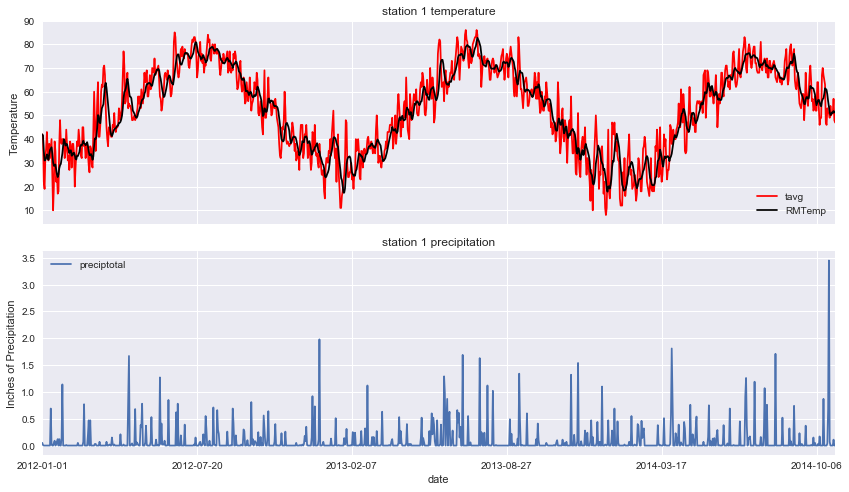

In [6]:
s1 = clean_weather.loc[weather_df.station_nbr == 1]
s1.set_index('date', inplace=True)
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(12,7))
s1['RMTemp'] = s1['tavg'].rolling(7, min_periods=1).mean()
s1.plot(y='tavg', ax=axes[0], title='station 1 temperature', color='red')
s1.plot(y='RMTemp', ax=axes[0], color = 'black')
axes[0].set_ylabel('Temperature')
s1.plot(y='preciptotal', ax=axes[1], title='station 1 precipitation')
axes[1].set_ylabel('Inches of Precipitation')
fig.tight_layout()
plt.show()

Using station 1 as an example for its temperature and precipitation plot, I can get an idea of what kind of weather each station is subject to. It has to be considered where these stations are generally located by their temperature patterns. This is important to think about since winter weather in colder climates is seen as standard and less likely to cause grocery store rushes, compared to winter weather in warmer climates. Also, deviations from normal temperatures of the season should also be considered. Sudden temperature changes, especially around winter time, may spur people to go to the store. Seen above, a rolling mean of the average temperature over 7 day periods was plotted on top of the average temperature plot to be able to help visualize sudden temperature changes.

### Data Wrangling and Exploratory Data Analysis:  Sales

In [8]:
sales_train = sales_train.replace(0, np.nan)
sales_train.dropna(inplace=True)
clean_sales = sales_train.sort_values(by = ['store_nbr', 'date'])
#clean_sales = pd.pivot_table(sales_train, values='units', index=['store_nbr', 'date'], columns=['item_nbr'])
clean_sales.head(5)

,date,store_nbr,item_nbr,units
8,2012-01-01,1,9,29.0
27,2012-01-01,1,28,2.0
50,2012-01-01,1,51,1.0
4892,2012-01-02,1,9,60.0
4911,2012-01-02,1,28,5.0


In [10]:
for s in range(1,46):
    top_sales = clean_sales.loc[clean_sales.store_nbr == s].groupby(['item_nbr'])['units'].sum().sort_values(ascending=False).head(5)
    if (s>0)&(s<4):
        print("Top Selling Items for Store %0.0f" % s)
        print(top_sales)
        print()

Top Selling Items for Store 1
item_nbr
9     27396.0
28     4893.0
47     2409.0
93     1103.0
51      925.0
Name: units, dtype: float64

Top Selling Items for Store 2
item_nbr
44    117125.0
5      55104.0
11       655.0
93       653.0
85       106.0
Name: units, dtype: float64

Top Selling Items for Store 3
item_nbr
45     64760.0
5      56663.0
109     1394.0
2       1083.0
93      1031.0
Name: units, dtype: float64



In [11]:
stores = [1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,10,10,10,10,10,
          11,11,11,11,11,12,12,12,12,12,13,13,13,13,13,14,14,14,14,14,15,15,15,15,15,16,16,16,16,16,17,17,17,17,
          18,18,18,18,19,19,19,19,19,20,20,20,20,20,21,21,21,21,22,22,22,22,22,23,23,23,23,24,24,24,24,24,
          25,25,25,25,25,26,26,26,27,27,27,27,27,28,28,28,28,29,29,29,29,30,30,30,30,30,31,31,31,31,31,32,32,32,32,32,
          33,33,33,33,33,34,34,34,34,34,35,35,35,35,35,36,36,36,36,37,37,37,37,37,38,38,38,38,38,39,39,39,39,
          40,40,40,40,40,41,41,41,41,41,42,42,42,43,43,43,43,43,44,44,44,44,44,45,45,45,45,45]
items = [9,28,47,93,51,44,5,11,93,85,45,5,109,2,93,9,27,90,97,96,16,37,93,20,32,45,9,107,14,5,23,95,93,7,5,23,93,59,
         100,45,5,42,93,10,5,37,93,21,86,68,9,110,87,61,16,37,93,79,86,36,5,93,46,104,25,9,15,93,70,45,5,15,93,61,
         25,16,77,64,93,9,48,37,71,5,37,72,57,16,83,15,69,93,5,41,74,93,18,44,5,109,91,9,68,93,78,54,45,5,56,29,43,6,
         97,60,76,9,45,81,93,12,45,5,2,9,68,93,21,80,45,5,35,2,45,8,41,56,44,16,13,65,51,45,9,67,98,93,45,9,93,58,19,
         44,9,92,93,85,45,9,52,31,93,16,66,24,63,50,44,9,30,1,5,45,38,15,53,45,9,52,93,98,36,9,111,103,45,5,55,93,15,
         16,68,108,93,61,45,5,82,16,37,3,93,73,68,5,93,94,62,9,26,50,4,22]
top = pd.DataFrame({'store_nbr': stores, 'item_nbr': items,})
clean_top_sales = pd.merge(clean_sales, top, left_on=['store_nbr','item_nbr'], right_on=['store_nbr', 'item_nbr'])
clean_top_sales = clean_top_sales.sort_values(by = ['store_nbr', 'date'])

I've cleaned up the sales data by sorting by the store number and date respectively. I have also removed any data that shows sales of zero. I chose to do this because of the overwhelming amount of data that has zero sales, and will help derive a more concise model later. On top of that decision, I also decided to only analyze and train my model for the top 5 items at each store (if there are 5 such weather-sensitive items remaining following the aforementioned data cleansing). The top 5 selling items for the first 3 stores in my dataset were printed above. Below, I will be plotting a time-series chart of sales for item 9 at store 1 for the year 2012 to get an idea of whether this particular item shows seasonal characteristics or not.

In [12]:
s1sales = clean_top_sales.loc[clean_top_sales.store_nbr == 1]
s1_i9 = s1sales.loc[s1sales.item_nbr == 9]
mask = (s1_i9['date'] >= '2012-01-01') & (s1_i9['date'] < '2013-01-01')
s1_i9_2012 = s1_i9.loc[mask]
s1_i9_2012.head()

,date,store_nbr,item_nbr,units
0,2012-01-01,1,9,29.0
1,2012-01-02,1,9,60.0
2,2012-01-03,1,9,15.0
3,2012-01-04,1,9,20.0
4,2012-01-05,1,9,16.0


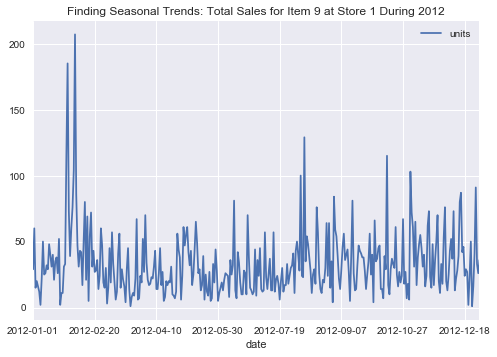

In [78]:
s1_i9_2012.plot(x='date', y='units', kind='line', title='Finding Seasonal Trends: Total Sales for Item 9 at Store 1 During 2012')
plt.show()

This particular item at store 1 seems to show relatively consistent sales, with slight increases in the fall and winter seasons, but not enough to classify it as a seasonal item for those seasons. Doing the same visual analysis for other items, there are a few items that indicate a seasonal buying pattern. To quantify this, I will be finding total monthly sales, that way I can assign indicator variables for each item if it is indeed a seasonal item, which will be later utilized in the model. Below, I will once again use item 9 at store 1 as an example of this analysis.

In [14]:
s1sales.drop(s1sales.columns[[1]], axis=1, inplace=True)
s1sales['date'] =  pd.to_datetime(s1sales['date'])
s1sales_total_i9 = s1sales['units'].loc[s1sales.item_nbr == 9].groupby([s1sales.item_nbr, s1sales.date.dt.year, s1sales.date.dt.month]).sum()
s1sales_total_i9

/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


item_nbr  date  date
9         2012  1       1169.0
                2       1438.0
                3        733.0
                4        724.0
                5        920.0
                6        735.0
                7        750.0
                8       1183.0
                9       1125.0
                10       964.0
                11      1146.0
                12      1149.0
          2013  1       1025.0
                2       1038.0
                3       1034.0
                4        956.0
                5       1020.0
                6        424.0
                7        426.0
                8        618.0
                9        590.0
                10       933.0
                11       481.0
                12       582.0
          2014  1       1011.0
                2        735.0
                3        697.0
                4        502.0
                5        600.0
                6        510.0
                7        252.0
                8 

From the data above, it is apparent that there is not a seasonal trend for this specific item at store 1. Conducting this analysis for all other popular items across all stores, the following seasonal trends were discovered:
- Store 1, Item 51: Winter
- Store 1, Item 93: Spring, Summer, Fall
- Store 3, Item 2: Spring
- Store 4, Item 97: Winter
- Store 4, Item 96: Winter
- Store 12, Item 93: Spring, Summer, Fall
- Store 13, Item 104: Winter
- Store 14, Item 15: Winter
- Store 15, Item 93: Summer
- Store 15, Item 15: Winter
- Store 19, Item 93: Summer and Fall
- Store 19, Item 15: Winter
- Store 24, Item 97: Winter
- Store 25, Item 93: Summer
- Store 37, Item 15: Winter
- Store 45, Item 50: Winter

Next I will merge the sales and weather data using the key dataset. This will allow me to find any relationships between sales and weather patterns.

In [15]:
sales_station = pd.merge(clean_top_sales, key, left_on='store_nbr', right_on='store_nbr')
sales_weather = pd.merge(sales_station, clean_weather, left_on=['date','station_nbr'], right_on=['date','station_nbr'])
sales_weather.head(10)

,date,store_nbr,item_nbr,units,station_nbr,tavg,preciptotal
0,2012-01-01,1,9,29.0,1,42,0.05
1,2012-01-01,1,28,2.0,1,42,0.05
2,2012-01-01,1,51,1.0,1,42,0.05
3,2012-01-02,1,9,60.0,1,41,0.01
4,2012-01-02,1,28,5.0,1,41,0.01
5,2012-01-02,1,51,1.0,1,41,0.01
6,2012-01-03,1,9,15.0,1,22,0.00
7,2012-01-03,1,28,9.0,1,22,0.00
8,2012-01-04,1,9,20.0,1,19,0.00
9,2012-01-04,1,28,3.0,1,19,0.00


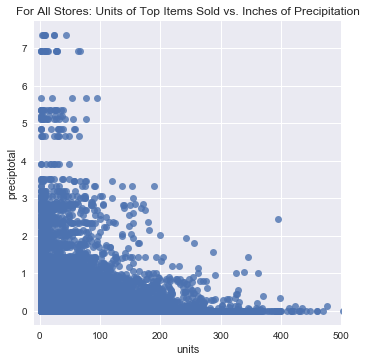

In [79]:
g = sns.lmplot(x='units', y='preciptotal', data=sales_weather, scatter=True, fit_reg=False)
g.set(xlim=(-10, 500))
plt.title('For All Stores: Units of Top Items Sold vs. Inches of Precipitation')
plt.show()

In terms of a general relationship, there does not seem to be a definite one between precipitation totals and sales of goods. To measure the influence of precipitation on sales, I will look at days where precipitation totals are more than the monthly average for precipitation and its impact on sales, compared to days where precipitation totals were below average. This test will give us a better idea of the relationship item sales have with precipitation.

### Inferential Statistics

In [18]:
sales_weather['date'] =  pd.to_datetime(sales_weather['date'])
sales_weather2 = pd.DataFrame()
for s in range(1,21):
    precip_avg = sales_weather.loc[sales_weather.station_nbr == s]
    p_avg = precip_avg['preciptotal'].groupby([precip_avg.date.dt.year, precip_avg.date.dt.month]).mean()
    p_avg.index.names = ('year', 'month')
    p_avg = p_avg.unstack(level=-1)
    p_avg = pd.melt(p_avg.reset_index(), id_vars=['year'], var_name="month", value_name="precip_M_mean")
    p_avg['day'] = 1
    p_avg['date'] = pd.to_datetime(p_avg[['year', 'month', 'day']])
    p_avg.drop(p_avg.columns[[0,1,3]], axis=1, inplace=True)
    p_avg.dropna(inplace=True)
    p_avg['station_nbr'] = s
    df = pd.merge(precip_avg, p_avg, how = 'left', left_on=['date','station_nbr'], right_on=['date','station_nbr'])
    df = df.fillna(method='ffill')
    sales_weather2 = sales_weather2.append(df, ignore_index = True)
sales_weather2 = sales_weather2.sort_values(by = ['store_nbr', 'date'])
#sales_weather2['precipAboveAvg'] = np.sign(sales_weather2.preciptotal - sales_weather2.precip_M_mean)
sales_weather2['precipAboveAvg'] = np.where(sales_weather2.preciptotal > sales_weather2.precip_M_mean, 1, 0)
sales_weather2.head()

,date,store_nbr,item_nbr,units,station_nbr,tavg,preciptotal,precip_M_mean,precipAboveAvg
0,2012-01-01,1,9,29.0,1,42,0.05,0.087375,0
1,2012-01-01,1,28,2.0,1,42,0.05,0.087375,0
2,2012-01-01,1,51,1.0,1,42,0.05,0.087375,0
3,2012-01-02,1,9,60.0,1,41,0.01,0.087375,0
4,2012-01-02,1,28,5.0,1,41,0.01,0.087375,0


Following calculations on monthly precipitation averages for each station, I added the respective values to the dataset, and also added an indicator column for whether that day's precipitation was above or below that calculated average. Now I can run the following two-tailed hypothesis test to measure any significance of above average precipitation:
- H0 (null hypothesis): Sales (during above average precipitation) = Sales (during below average precipitation)
- HA (alternate hypothesis): Sales (during below average precipitation) =/= Sales (during above average precipitation)

In [20]:
aboveAvg = sales_weather2[sales_weather2.precipAboveAvg == 1]['units']
belowAvg = sales_weather2[sales_weather2.precipAboveAvg == 0]['units']
print("Sales during above average precipitation:")
print(aboveAvg.describe())
print()
print("Sales during below average precipitation:")
print(belowAvg.describe())

Sales during above average precipitation:
count    18358.000000
mean        38.425101
std         50.732177
min          1.000000
25%          5.000000
50%         24.000000
75%         55.000000
max       3369.000000
Name: units, dtype: float64

Sales during below average precipitation:
count    91952.000000
mean        40.825735
std         49.186726
min          1.000000
25%          5.000000
50%         28.000000
75%         59.000000
max       5568.000000
Name: units, dtype: float64


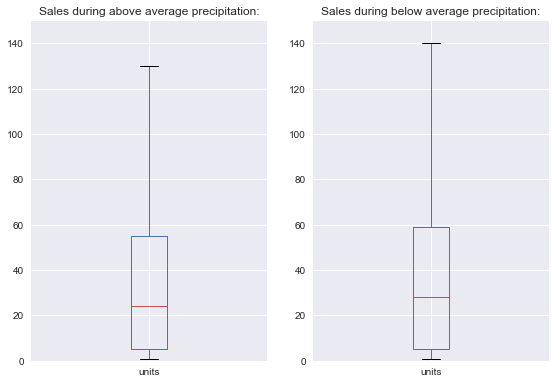

In [25]:
plt.subplot(1,2,1)
aboveAvg.plot(kind='box')
plt.ylim((0,150))
plt.title('Sales during above average precipitation:')
plt.subplot(1,2,2)
belowAvg.plot(kind='box')
plt.ylim((0,150))
plt.title('Sales during below average precipitation:')
plt.tight_layout()
plt.show()

From the statistical descriptions above, it looks like there is a significant difference in sample sizes. However from this, the relative means are close, as well as the spread of data, which can be visualized in the box plots above. The plots also indicate that the data is not close enough to normal, therefore I will not be able to use the t-test for this hypothesis. As the conditions are met for independence and relatively identical distributions between datasets, I will be utilizing the two-sided Wilcoxon rank sum test to calculate a test-statistic and p-value for this hypothesis.

In [26]:
import scipy.stats as stats
statistic, pvalue = stats.ranksums(aboveAvg, belowAvg)
print('Wilcoxon Rank Sum Test: [test statistic: %4.5f, p-value: %4.15f]' % (statistic, pvalue))

Wilcoxon Rank Sum Test: [test statistic: -7.29812, p-value: 0.000000000000292]


The results show a very large test statistic, resulting in an extremely small p-value. Following this test, I can reject the null hypothesis of there being no significant sales difference during above average and below average precipitation. According to the reported p-value, we are taking a 0.0000000000292% chance that this conclusion is wrong. Based on these results, I feel confident to include the indicator variables found above in the later model.

### Derivation of Predictive Model:  Will weather be the most significant feature in predicting sales?

As I am predicting sales, which is a continuous variable, I will be utilizing a multivariable linear regression to derive my model. Along with the continuous variables included in the dataset above, like average temperature and precipitation, indicator variables will be included for above average precipitation and seasonal trends, as well as date subjective indicator variables like whether a certain day falls on a weekend or during a holiday. I will engineer the remaining features below before deriving my linear model.

In [48]:
# adding seasonal item features
stores = [1,1,3,4,4,12,13,14,15,15,19,19,24,25,37,45]
items = [51,93,2,97,96,93,104,15,93,15,93,15,97,93,15,50]
df = pd.DataFrame({'store_nbr':stores, 'item_nbr':items})
df['isWinter'] = 0
df['isSpring'] = 0
df['isSummer'] = 0
df['isFall'] = 0
df['isWinter'] = np.where((df.store_nbr == 1) & (df.item_nbr == 51) |
                          (df.store_nbr == 4) & (df.item_nbr == 97) | 
                          (df.store_nbr == 4) & (df.item_nbr == 96) |
                          (df.store_nbr == 13) & (df.item_nbr == 104) |
                          (df.store_nbr == 14) & (df.item_nbr == 15) |
                          (df.store_nbr == 15) & (df.item_nbr == 15) |
                          (df.store_nbr == 19) & (df.item_nbr == 15) |
                          (df.store_nbr == 24) & (df.item_nbr == 97) |
                          (df.store_nbr == 37) & (df.item_nbr == 15) |
                          (df.store_nbr == 45) & (df.item_nbr == 50), 1, 0)
df['isSpring'] = np.where((df.store_nbr == 1) & (df.item_nbr == 93) |
                          (df.store_nbr == 3) & (df.item_nbr == 2) |
                          (df.store_nbr == 12) & (df.item_nbr == 93), 1, 0)
df['isSummer'] = np.where((df.store_nbr == 1) & (df.item_nbr == 93) |
                          (df.store_nbr == 12) & (df.item_nbr == 93) |
                          (df.store_nbr == 15) & (df.item_nbr == 93) |
                          (df.store_nbr == 19) & (df.item_nbr == 93) |
                          (df.store_nbr == 25) & (df.item_nbr == 93), 1, 0)
df['isFall'] = np.where((df.store_nbr == 1) & (df.item_nbr == 93) |
                        (df.store_nbr == 12) & (df.item_nbr == 93) |
                        (df.store_nbr == 19) & (df.item_nbr == 93), 1, 0)
sales_weather3 = pd.merge(sales_weather2, df, how='left', left_on=['store_nbr','item_nbr'], right_on=['store_nbr','item_nbr'])
sales_weather3 = sales_weather3.fillna(0)
sales_weather3.head()

,date,store_nbr,item_nbr,units,station_nbr,tavg,preciptotal,precip_M_mean,precipAboveAvg,isWinter,isSpring,isSummer,isFall
0,2012-01-01,1,9,29.0,1,42,0.05,0.087375,0,0.0,0.0,0.0,0.0
1,2012-01-01,1,28,2.0,1,42,0.05,0.087375,0,0.0,0.0,0.0,0.0
2,2012-01-01,1,51,1.0,1,42,0.05,0.087375,0,1.0,0.0,0.0,0.0
3,2012-01-02,1,9,60.0,1,41,0.01,0.087375,0,0.0,0.0,0.0,0.0
4,2012-01-02,1,28,5.0,1,41,0.01,0.087375,0,0.0,0.0,0.0,0.0


In [103]:
# adding weekend feature: saturday and sunday have dayofweek values of 5 and 6
sales_weather3['isWeekend'] = ((pd.DatetimeIndex(sales_weather3.date).dayofweek) > 4).astype(float)

# adding holiday feature
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=sales_weather3.date.min(), end=sales_weather3.date.max())
sales_weather3['isHoliday'] = sales_weather3['date'].isin(holidays).astype(float)
sales_weather3['isTopItem'] = sales_weather3['item_nbr']
sales_weather3.head()

,date,store_nbr,item_nbr,units,station_nbr,tavg,preciptotal,precip_M_mean,precipAboveAvg,isWinter,isSpring,isSummer,isFall,isWeekend,isHoliday,isTopItem
0,2012-01-01,1,9,29.0,1,42,0.05,0.087375,0,0.0,0.0,0.0,0.0,1.0,0.0,9
1,2012-01-01,1,28,2.0,1,42,0.05,0.087375,0,0.0,0.0,0.0,0.0,1.0,0.0,28
2,2012-01-01,1,51,1.0,1,42,0.05,0.087375,0,1.0,0.0,0.0,0.0,1.0,0.0,51
3,2012-01-02,1,9,60.0,1,41,0.01,0.087375,0,0.0,0.0,0.0,0.0,0.0,1.0,9
4,2012-01-02,1,28,5.0,1,41,0.01,0.087375,0,0.0,0.0,0.0,0.0,0.0,1.0,28


Now that the remaining features are engineered and included into our dataset, I can now derive a multivariable linear regression to model this data. Remember, since there is no continuity of items across different stores, I will have to run regressions for each store. Again, I will use store 1 as an example, and will later extract $R^2$ values for each store's model.

In [104]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
store_data = sales_weather3.loc[sales_weather3.store_nbr == 1]
X = store_data.drop(store_data.columns[[0,1,2,3,4,7]], axis=1)
y = store_data.units
lm = LinearRegression()
lm.fit(X,y)
print('Store 1 Model Description:')
print('Estimated intercept coefficient: {}'.format(lm.intercept_))
print('Number of coefficients: {}'.format(len(lm.coef_)))
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

Store 1 Model Description:
Estimated intercept coefficient: 33.76017060947457
Number of coefficients: 10


,features,estimatedCoefficients
0,tavg,-0.049475
1,preciptotal,-0.886535
2,precipAboveAvg,-0.293186
3,isWinter,9.240255
4,isSpring,14.269872
5,isSummer,14.269872
6,isFall,14.269872
7,isWeekend,7.094201
8,isHoliday,3.124564
9,isTopItem,-0.753320


Each model consists of 10 different coefficients, with calculated intercepts. Now I will test the resulting sales predictions against the actual sales to arrive at an $R^2$ value for each store's model.

In [135]:
store_num = []
r2_values = []
date12 = y12 = pred_y12 = date37 = y37 = pred_y37 = None
item_num12 = item_num37 = None
for store in range(1,46):
    store_data = sales_weather3.loc[sales_weather3.store_nbr == store]
    if(store==12):
        date12 = store_data.date
        item_num12 = store_data.item_nbr
    elif(store==37):
        date37 = store_data.date
        item_num37 = store_data.item_nbr
    X = store_data.drop(store_data.columns[[0,1,2,3,4,7]], axis=1)
    y = store_data.units
    lm = LinearRegression()
    lm.fit(X,y)
    pred_y = lm.predict(X)
    if(store==12):
        y12 = y
        pred_y12 = pred_y
    elif(store==37):
        y37 = y
        pred_y37 = pred_y
    store_num.append(store)
    r2_values.append(r2_score(y, pred_y))
df = pd.DataFrame({'store_nbr':store_num, 'r2_values':r2_values})
print(df.sort_values(by='r2_values', ascending=False).head(1)) # top r2 value
print(df.sort_values(by='r2_values', ascending=True).head(1)) # lowest r2 value

    r2_values  store_nbr
11   0.620121         12
    r2_values  store_nbr
36   0.010686         37


Observing the calculated coefficients for store 1, an initial intercept of 33 is extracted. The resulting coefficients will be discussed below in the conclusion. According to the highest and lowest calculated $R^2$ values above, we can see that small percentages of the variance in sales can be explained by each respective model. The highest $R^2$ calculated was for store 12, with a value of 0.62, where as the lowest was 0.01 for store 37. To observe this, I will plot store 12's actual and predicted sales against each other for its most popular item (item 93), as well as store 37's actual and predicted sales for its most popular item (item 15) on another plot.

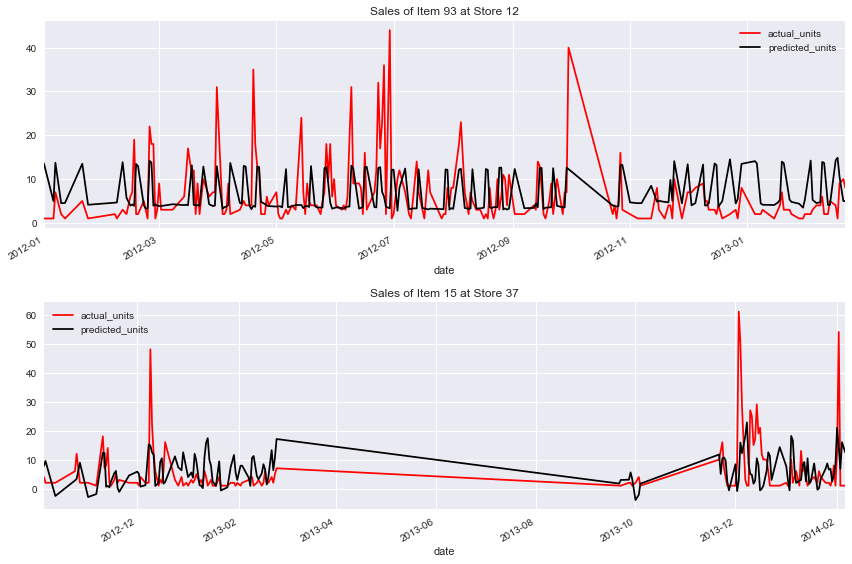

In [149]:
df12 = pd.DataFrame({'date':date12, 'item_nbr':item_num12, 'actual_units':y12, 'predicted_units':pred_y12})
df12_i93 = df12.loc[df12.item_nbr == 93]
df37 = pd.DataFrame({'date':date37, 'item_nbr':item_num37, 'actual_units':y37, 'predicted_units':pred_y37})
df37_i15 = df37.loc[df37.item_nbr == 15]
fig2, axes2 = plt.subplots(nrows=2,ncols=1, figsize=(12,8))
df12_i93.plot(x='date', y='actual_units', ax=axes2[0], title='Sales of Item 93 at Store 12', color='red')
df12_i93.plot(x='date', y='predicted_units', ax=axes2[0], color='black')
df37_i15.plot(x='date', y='actual_units', ax=axes2[1], title='Sales of Item 15 at Store 37', color='red')
df37_i15.plot(x='date', y='predicted_units', ax=axes2[1], color='black')
plt.tight_layout()
plt.show()

Both items analyzed above are top selling items for their respective stores, and are both seasonal. Item 93 at store 12 was recognized to have buying patterns for all seasons except winter. However, the predicted model does not reflect that, and shows relatively consistent sales predictions during winter as it does during other seasons. For item 15 at store 37, it is a seasonal item for winter, and the predictive model does reflect that. Aside from large sales peaks, the model does a good job of predicting sales. In this case for both items and both stores, their respective $R^2$ values may not be representative of the modeling for the other items, and could account for the observed difference in $R^2$ values.

### Conclusion and Suggestion

Following the analysis above, I can come to some solid conclusions related to the data. Weather related features look to have a very minimal effect on the sales output, a negative impact at that. As expected, seasonal indicators are positive for the respective seasons an item is popular. Aside from that feature, weekends seem to have the largest positive impact on the sales of items. This was expected, as people have more leisure time during weekends than during the week. Also observed is the positive impact on sales that holidays have, however that impact is small in comparison to the impact of weekends. Despite there being a belief that severe weather causes massive store rushes, I have come to the conclusion that weekends and holidays have more of an impact on sales than weather, as well as when it is peak buying season for certain items. Therefore, from a business perspective, I would suggest to store managers not to overestimate weather related inventory calculations because of inconsistency, and instead focus on weekend and holiday shopping rushes to maximize sales.